In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# 1) Importations

In [2]:
%pylab inline
import pandas as pd
import os
import seaborn as sns
from sklearn import preprocessing

Populating the interactive namespace from numpy and matplotlib


# 2) Open data and look into it

In [3]:
# Getting current path
path = os.getcwd()
try :
    data_raw = pd.read_excel(path + "/data/Online_Retail.xlsx")
    print("Loading dataset")
    display(data_raw.head())
except ImportError:
    print("ERROR : check if the 'Online_Retail.xlsx' file is in the 'data' folder")

Loading dataset


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 3) Cleaning

# 3.1) Duplicates

In [4]:
# Getting rid of the duplicates
print("initial shape : ", data_raw.shape)
dup = data_raw[data_raw.duplicated()].shape[0]
if dup > 0 :
    print("duplicates found : ", dup)
    data_raw = data_raw.drop_duplicates(keep='first')
    print("Shape without duplicates: ", data_raw.shape)
else :
    print("No duplicate")

initial shape :  (541909, 8)
duplicates found :  5268
Shape without duplicates:  (536641, 8)


# 3.2) Missing values

In [5]:
# Looking for missing values
missing_val_df = data_raw.isnull().sum(axis=0).reset_index()
missing_val_df.columns = ['feature', 'missing values']
missing_val_df['missing values (%)']=100 - ((data_raw.shape[0]-missing_val_df['missing values'])/data_raw.shape[0]*100)
missing_val_df = missing_val_df.sort_values('missing values (%)', ascending=False)
missing_val_df

,feature,missing values,missing values (%)
6,CustomerID,135037,25.163377
2,Description,1454,0.270945
0,InvoiceNo,0,0.000000
1,StockCode,0,0.000000
3,Quantity,0,0.000000
4,InvoiceDate,0,0.000000
5,UnitPrice,0,0.000000
7,Country,0,0.000000


As *'CustomerID'* will be our main concern to build customers behaviours, we delete those missing customerID values

In [6]:
data_raw = data_raw.dropna()
print("New shape : ", data_raw.shape)
data_raw.isnull().sum()

New shape :  (401604, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

# 3.3) Looking for errors in the dataset

In [7]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      401604 non-null object
StockCode      401604 non-null object
Description    401604 non-null object
Quantity       401604 non-null int64
InvoiceDate    401604 non-null datetime64[ns]
UnitPrice      401604 non-null float64
CustomerID     401604 non-null float64
Country        401604 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.6+ MB


'InvoiceNo' is object type because some have been canceled and are therefore preceded by a 'C'

# 4) Exploration

In [8]:
data_raw_explo = data_raw.copy()

Number and origin of unique customers

In [9]:
customers_counts = data_raw_explo.loc[:, 'CustomerID'].value_counts()
countries_counts = pd.DataFrame(data_raw_explo.loc[:, 'Country'].value_counts(), columns=['Country'])
print("We count %i unique customers coming from %i countries" % (customers_counts.shape[0], countries_counts.shape[0]))

We count 4372 unique customers coming from 37 countries


Group countries that account for less than 0.5% of orders in "other" category

In [10]:
# Getting percentage of country representation over customers
countries_counts.loc[:, 'perc'] = countries_counts.loc[:, 'Country'].apply(lambda x : x * 100 / countries_counts.loc[:, 'Country'].sum())
# Attributing 'Other' origin for small amount of orders
countries_counts.loc[:, 'Origin'] = countries_counts.apply(lambda x : x.name if x['perc'] >= 0.5 else 'Other', axis=1)
# Aggregating by Origin
grouped = countries_counts.groupby('Origin')
countries_counts_other = grouped.agg(np.sum)

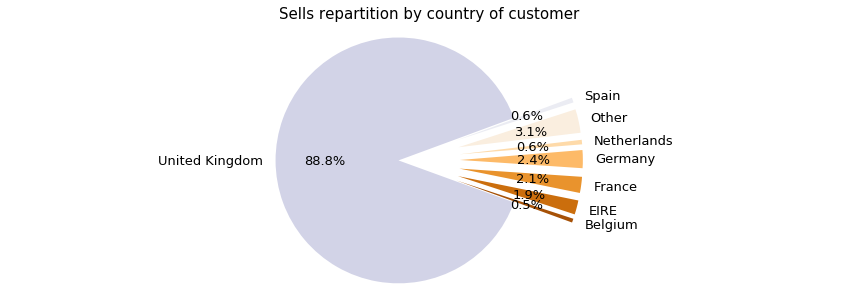

In [11]:
# Pie chart
fig, ax = plt.subplots(figsize=(15,5))
# Explode for small accounts
explode = [0.5 if countries_counts_other['perc'][i] <= 4 else 0.0 for i in range(len(countries_counts_other.values))]
ax.pie(countries_counts_other['Country'].values, labels=countries_counts_other.index.values, autopct='%.1f%%',
       explode=explode, textprops={'fontsize': 13}, startangle=340, colors=sns.color_palette("PuOr", 12))
ax.axis('equal');  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Sells repartition by country of customer', fontsize=15);

As most of customers comes from UK, and that customers behaviours most likely differ from one country to another, we will limit the analysis to UK customers.

In [12]:
data_raw_explo = data_raw_explo[data_raw_explo.Country == 'United Kingdom']
print("New shape : ", data_raw_explo.shape)

New shape :  (356728, 8)


Label encoding with Customers ID

In [13]:
# Get Customers ID
le_id = preprocessing.LabelEncoder()
le_id = le_id.fit(data_raw_explo.loc[:, 'CustomerID'].dropna().values)
data_raw_explo.loc[:, 'CustomerID_enc'] = data_raw_explo.loc[:, 'CustomerID'].apply(lambda x : int(le_id.transform([x])) if not bool(np.isnan(x)) else x)

New customers count

In [14]:
customers_counts = data_raw_explo.loc[:, 'CustomerID_enc'].value_counts()

C:\Users\simon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


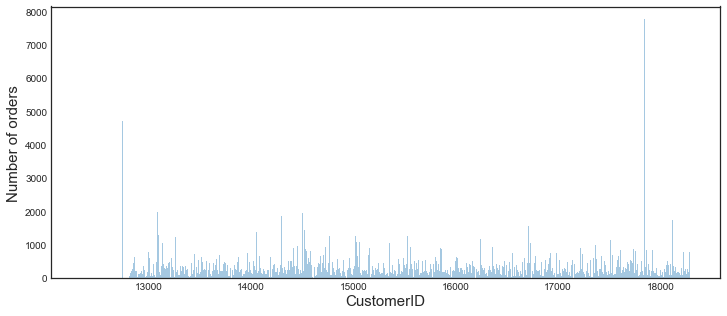

In [96]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.distplot(data_raw_explo.loc[:, 'CustomerID'], kde=False, bins=1100)
# Add axes labels
ax.set_xlabel('CustomerID', fontsize=15)
ax.set_ylabel('Number of orders', fontsize=15);

We can observe a few big customers but most of customers placed an amount of orders bellow 500

In [97]:
customers_counts_df = pd.DataFrame(customers_counts.values, columns=['counts'])
customers_counts_df['cust_enc_id'] = customers_counts.index.values
customers_counts.describe(percentiles=[0.25,0.5,0.75,0.95,0.99])

count    3950.000000
mean       90.310886
std       216.804909
min         1.000000
25%        17.000000
50%        41.000000
75%        99.000000
95%       314.000000
99%       659.590000
max      7812.000000
Name: CustomerID_enc, dtype: float64

In numbers 95% of the customers placed 314 orders or less

In order to capitalise on the customers buying activity to infer a behaviour, we can't use the cancellations invoices neither can we use other kind of invoices (merchandise thrown away, damaged etc).

Let's get rid of this cancellations. Notice that those may be interesting to study in order to look into the reasons of those cancellations. But this is not our purpose here.

In [17]:
print("Shape before removing cancellations : ", data_raw_explo.shape)
data_raw_explo = data_raw_explo[data_raw_explo.Quantity > 0]
print("Shape after removing cancellations : ", data_raw_explo.shape)

Shape before removing cancellations :  (356728, 9)
Shape after removing cancellations :  (349227, 9)


Does the unit price evolves over time ? YES but no pattern

StockCode sample : 82582


2.10    336
1.85     22
4.13      5
1.69      3
Name: UnitPrice, dtype: int64

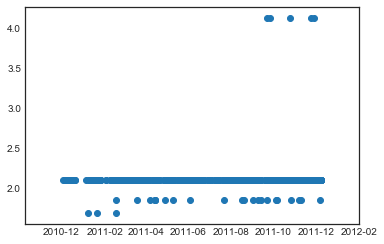

In [18]:
stockcode_samp = data_raw_explo.StockCode.sample().values
print("StockCode sample : %s" % stockcode_samp[0])
data_stockcode_samp = data_raw_explo.loc[:, ['InvoiceDate', 'Quantity', 'UnitPrice']][data_raw_explo.StockCode == stockcode_samp[0]]
plt.scatter(data_stockcode_samp.InvoiceDate.values, data_stockcode_samp.UnitPrice.values)
data_stockcode_samp.UnitPrice.value_counts()

Frequency of orders over time

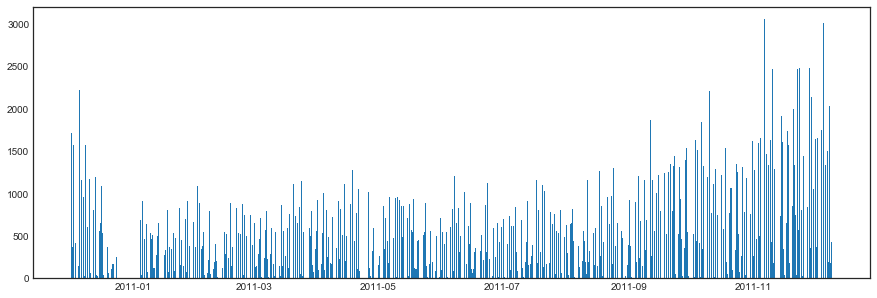

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
counts, bins, bars = plt.hist(data_raw_explo.InvoiceDate.values, bins=1000);

We can observe a rise in the orders close to the end of the year, which is consistent with the holidays period. Moreover the website seem closed from december the 24th to january the 4th.

Creating an amount feature (quantity * unitprice)

In [20]:
data_raw_explo['Amount'] = data_raw_explo['Quantity'] * data_raw_explo['UnitPrice']

Looking for zeros in amounts : free order that might be gifts

In [21]:
# Columns with zeros
col_zeros = data_raw_explo.columns[(data_raw_explo == 0).any()]
display(col_zeros)

Index(['UnitPrice', 'CustomerID_enc', 'Amount'], dtype='object')

CustomerID_enc has a zero, no chocking

In [22]:
data_raw_explo.loc[:, col_zeros].sort_values(by=['Amount']).head()

,UnitPrice,CustomerID_enc,Amount
454463,0.0,189,0.0
436597,0.0,920,0.0
47068,0.0,189,0.0
47070,0.0,189,0.0
446794,0.0,829,0.0


In [103]:
data_test = data_raw.copy()
data_test['Amount'] = data_test['Quantity'] * data_test['UnitPrice']
data_test[data_test.Amount == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,0.0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,0.0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,0.0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0.0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0.0


In [121]:
datetime.datetime(2010,12,1,20,0,0)

datetime.datetime(2010, 12, 1, 20, 0)

In [145]:
data_test[(data_test.InvoiceDate >= datetime.datetime(2010,12,23,16,5,0))].iloc[86:90]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
42451,539988,22854,CREAM SWEETHEART EGG HOLDER,2,2010-12-23 16:06:00,4.95,18116.0,United Kingdom,9.9
42452,539988,47559B,TEA TIME OVEN GLOVE,2,2010-12-23 16:06:00,1.25,18116.0,United Kingdom,2.5
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom,19.5
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,10.5


Some zeros indeed, we won't be interested in those

In [23]:
print("Shape before removing free orders : ", data_raw_explo.shape)
data_raw_explo = data_raw_explo[data_raw_explo.Amount > 0]
print("Shape after removing free orders : ", data_raw_explo.shape)

Shape before removing free orders :  (349227, 10)
Shape after removing free orders :  (349203, 10)


## Studying if customers are more likely to be bulk buyers or particular ones

**_New feature : Quantity / (UnitPrice + 1) ratio_**, we add 1 to the denominator in order to avoid increasing the ratio by dividing by something smaller than 1.

In [24]:
data_raw_explo['Bulk'] = data_raw_explo.loc[:, 'Quantity'] / data_raw_explo.loc[:, 'UnitPrice'].apply(lambda x : x + 1)

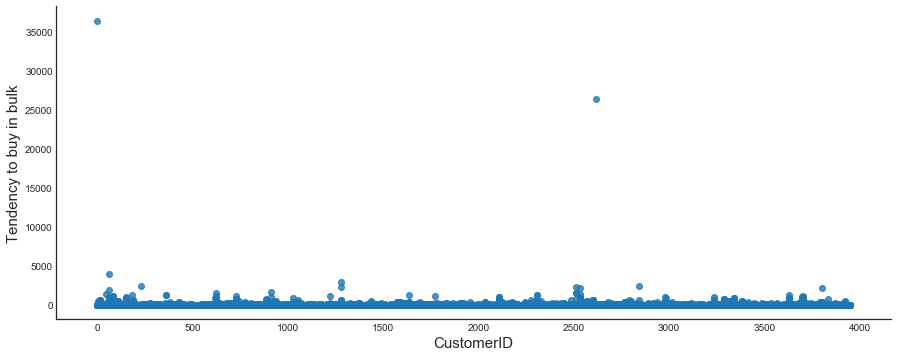

In [25]:
# Set seaborn style
sns.set_style("white")
# Seaborn scatter plot
sns.lmplot('CustomerID_enc', 'Bulk', data=data_raw_explo, fit_reg=False, aspect=2.5)
# Add axes labels
ax = plt.gca()
ax.set_xlabel('CustomerID', fontsize=15)
ax.set_ylabel('Tendency to buy in bulk', fontsize=15);

We spot 2 outliers, let's verify if it bulk orders as it seems to be

In [26]:
data_raw_explo.sort_values(by='Bulk', ascending=False).head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_enc,Amount,Bulk
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,0,77183.6,36379.901961
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2619,168469.6,26297.077922


Well it is very true for those two fellows, what about the smaller ones ?

In [27]:
data_raw_explo.sort_values(by='Bulk', ascending=False).head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_enc,Amount,Bulk
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,0,77183.60,36379.901961
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2619,168469.60,26297.077922
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom,61,1008.00,3966.942149
270885,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,2011-07-19 17:04:00,0.06,14609.0,United Kingdom,1279,191.16,3005.660377
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom,228,3096.00,2500.000000
4945,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,2010-12-02 17:38:00,0.18,16754.0,United Kingdom,2842,518.40,2440.677966
433788,573995,16014,SMALL CHINESE STYLE SCISSOR,3000,2011-11-02 11:24:00,0.32,16308.0,United Kingdom,2514,960.00,2272.727273
91772,544152,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,2400,2011-02-16 12:10:00,0.06,14609.0,United Kingdom,1279,144.00,2264.150943
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom,3801,3202.92,2146.153846
80742,543057,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2592,2011-02-03 10:50:00,0.21,16333.0,United Kingdom,2531,544.32,2142.148760


Again, those buy rather by large amounts of cheap items.

What about those who buy a few expensive things ?

In [28]:
data_raw_explo.sort_values(by='Bulk', ascending=True).head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_enc,Amount,Bulk
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,2310,8142.75,0.000123
374542,569382,M,Manual,1,2011-10-03 16:44:00,3155.95,15502.0,United Kingdom,1919,3155.95,0.000317
297438,562946,M,Manual,1,2011-08-11 09:38:00,2500.00,15581.0,United Kingdom,1982,2500.00,0.000400
343000,566927,M,Manual,1,2011-09-15 15:20:00,2033.10,17846.0,United Kingdom,3623,2033.10,0.000492
150615,549468,M,Manual,1,2011-04-08 14:27:00,1867.86,17940.0,United Kingdom,3697,1867.86,0.000535
528082,580727,DOT,DOTCOM POSTAGE,1,2011-12-05 17:17:00,1599.26,14096.0,United Kingdom,909,1599.26,0.000625
508459,579196,DOT,DOTCOM POSTAGE,1,2011-11-28 15:54:00,1526.76,14096.0,United Kingdom,909,1526.76,0.000655
467436,576339,DOT,DOTCOM POSTAGE,1,2011-11-14 15:27:00,1500.36,14096.0,United Kingdom,909,1500.36,0.000666
494728,578270,DOT,DOTCOM POSTAGE,1,2011-11-23 13:39:00,1270.06,14096.0,United Kingdom,909,1270.06,0.000787
455261,575607,DOT,DOTCOM POSTAGE,1,2011-11-10 12:37:00,908.16,14096.0,United Kingdom,909,908.16,0.001100


Many 'POST' or 'Manual' or 'DOTCOM POSTAGE' ?

In [29]:
number = data_raw_explo[data_raw_explo.StockCode.isin(['POST', 'M', 'DOT'])].shape[0]
print("%i of those found in the dataset, that is to say %.3f %% of the dataset" % (number, number / data_raw_explo.shape[0] * 100))

286 of those found in the dataset, that is to say 0.082 % of the dataset


Well this is expensive things indeed, but those are not usual items for sale. It appears that manuals and shipment may be very expensive, we will not consider those items for our customers analysis.

Separating those "other codes" :

- Convert stock codes to strings

In [30]:
data_raw_explo.StockCode = data_raw_explo.StockCode.astype(str)

List stock codes

In [31]:
stock_codes = []
other_codes = []
for code in data_raw_explo.StockCode.unique() :
    if code[0].isdigit() :
        stock_codes.append(code)
    else :
        other_codes.append(code)

In [32]:
print(other_codes)

['M', 'BANK CHARGES', 'C2', 'POST', 'PADS', 'DOT']


- POST : Expedition cost
-  C2  : Carriage cost
- DOT  : DOTCOM Expedition cost
-  M   : Manual order (is it really manuals ?)
- PADS : Pad for cunshion, actual product ?
- BANK CHARGES : Bank fees

Select the data about actual sold items

In [33]:
data_stock_codes = data_raw_explo[data_raw_explo.StockCode.isin(stock_codes)]
n_other_codes = data_raw_explo[data_raw_explo.StockCode.isin(other_codes)].shape[0]
print("'Only' %i 'other codes' that is to say %.2f %% of the data" % (n_other_codes, n_other_codes * 100 / data_raw_explo.shape[0]))

'Only' 331 'other codes' that is to say 0.09 % of the data


Let's see again the 'selective' buyers

In [34]:
data_stock_codes.sort_values(by='Bulk', ascending=True).head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_enc,Amount,Bulk
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098.0,United Kingdom,1619,649.5,0.001537
171178,551393,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-04-28 12:22:00,295.0,14973.0,United Kingdom,1529,295.0,0.003378
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.0,17406.0,United Kingdom,3308,295.0,0.003378
82768,543253,22655,VINTAGE RED KITCHEN CABINET,1,2011-02-04 15:32:00,295.0,14842.0,United Kingdom,1444,295.0,0.003378
205759,554836,22655,VINTAGE RED KITCHEN CABINET,1,2011-05-26 16:25:00,295.0,13015.0,United Kingdom,143,295.0,0.003378


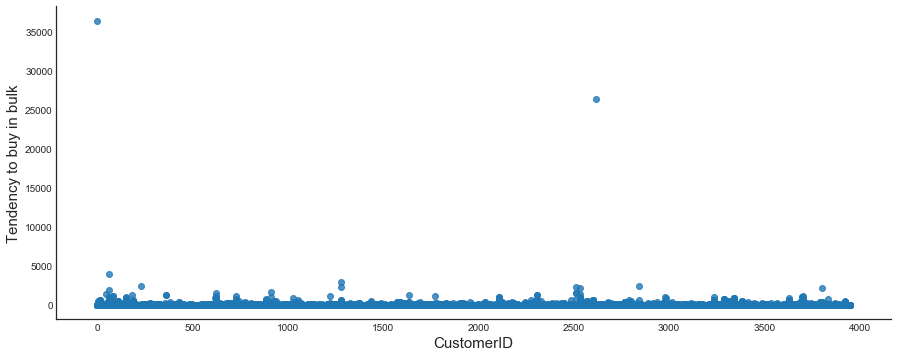

In [35]:
# Set seaborn style
sns.set_style("white")
# Seaborn scatter plot
sns.lmplot('CustomerID_enc', 'Bulk', data=data_stock_codes, fit_reg=False, aspect=2.5)
# Add axes labels
ax = plt.gca()
ax.set_xlabel('CustomerID', fontsize=15)
ax.set_ylabel('Tendency to buy in bulk', fontsize=15);

Much better

Same considerations but averaged by order (invoice)

In [36]:
invoice_df = data_stock_codes.groupby('InvoiceNo').agg({'CustomerID_enc': lambda x: x.mean(),
                                                        'Quantity': lambda x: x.mean(),
                                                        'UnitPrice': lambda x: x.mean(),
                                                        'Bulk': lambda x: x.mean()})
invoice_df.head()

,CustomerID_enc,Quantity,UnitPrice,Bulk
InvoiceNo,,,,
536365,3626,5.714286,3.910000,1.328253
536366,3626,6.000000,1.850000,2.105263
536367,165,6.916667,4.853333,1.941843
536368,165,3.750000,4.775000,0.663866
536369,165,3.000000,5.950000,0.431655


In [37]:
customer_invoice_df = invoice_df.groupby('CustomerID_enc').agg({'CustomerID_enc': lambda x: x.mean(),
                                                                'Quantity': lambda x: x.mean(),
                                                                'UnitPrice': lambda x: x.mean(),
                                                                'Bulk': lambda x: x.mean()})
customer_invoice_df.head()

,CustomerID_enc,Quantity,UnitPrice,Bulk
CustomerID_enc,,,,
0,0,74215.000000,1.040000,36379.901961
1,1,12.796737,4.253949,3.543142
2,2,8.900291,2.728614,5.151464
3,3,6.567653,4.812586,2.095416
4,4,12.361742,1.902633,6.277319


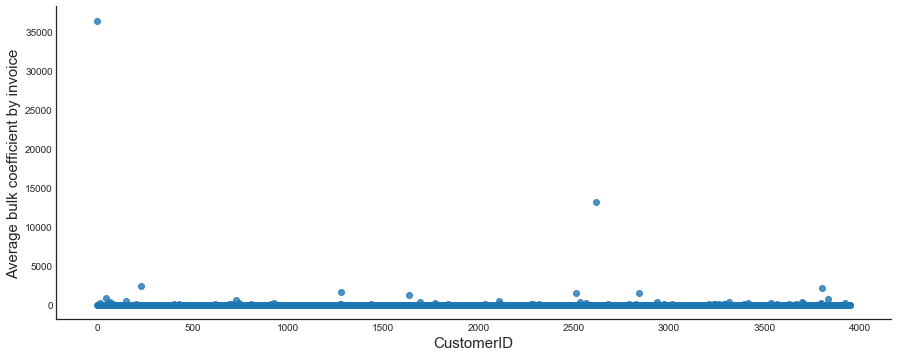

In [38]:
# Set seaborn style
sns.set_style("white")
# Seaborn scatter plot
sns.lmplot('CustomerID_enc', 'Bulk', data=customer_invoice_df, fit_reg=False, aspect=2.5)
# Add axes labels
ax = plt.gca()
ax.set_xlabel('CustomerID', fontsize=15)
ax.set_ylabel('Average bulk coefficient by invoice', fontsize=15);

# 5) New Datasets by customer

## 5.1) New Dataset by customer according to 1st and main items ordered

In [39]:
customers_df = pd.DataFrame(np.sort(data_stock_codes.CustomerID_enc.unique()), columns=['ID_enc'])
customers_df['ID'] = le_id.inverse_transform(customers_df['ID_enc'].values.astype('int64'))

C:\Users\simon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


First order specifics

In [40]:
customers_df['1st_order'] = customers_df.ID.apply(lambda x : data_stock_codes.StockCode[data_stock_codes.CustomerID == x].iloc[0])
customers_df['1st_order_qty'] = customers_df.ID.apply(lambda x : data_stock_codes.Quantity[data_stock_codes.CustomerID == x].iloc[0])
customers_df['1st_order_descr'] = customers_df.ID.apply(lambda x : data_stock_codes.Description[data_stock_codes.CustomerID == x].iloc[0])
customers_df['1st_order_amount'] = customers_df.ID.apply(lambda x : data_stock_codes.Amount[data_stock_codes.CustomerID == x].iloc[0])

Most frequent order specifics

In [41]:
print("Product")
customers_df['mf_order'] = customers_df.ID.apply(lambda x : data_stock_codes.StockCode[data_stock_codes.CustomerID == x].value_counts().index.values[0])
print("Quantity")
customers_df['mf_order_qty'] = customers_df.mf_order.apply(lambda x : data_stock_codes.Quantity[data_stock_codes.StockCode == x].value_counts().index.values[0])
print("Description")
customers_df['mf_order_descr'] = customers_df.mf_order.apply(lambda x : data_stock_codes.Description[data_stock_codes.StockCode == x].iloc[0])
print("Amount")
customers_df['mf_order_amount'] = customers_df.mf_order.apply(lambda x : data_stock_codes.Amount[data_stock_codes.StockCode == x].value_counts().index.values[0])

Product
Quantity
Description
Amount


In [42]:
customers_df.head()

,ID_enc,ID,1st_order,1st_order_qty,1st_order_descr,1st_order_amount,mf_order,mf_order_qty,mf_order_descr,mf_order_amount
0,0,12346.0,23166,74215,MEDIUM CERAMIC TOP STORAGE JAR,77183.60,23166,12,MEDIUM CERAMIC TOP STORAGE JAR,15.00
1,1,12747.0,85124C,12,GREEN JUICY FRUIT PHOTO FRAME,30.60,82484,2,WOOD BLACK BOARD ANT WHITE FINISH,15.90
2,2,12748.0,22854,1,CREAM SWEETHEART EGG HOLDER,4.95,21034,1,REX CASH+CARRY JUMBO SHOPPER,0.95
3,3,12749.0,22768,2,FAMILY PHOTO FRAME CORNICE,19.90,22171,2,3 HOOK PHOTO SHELF ANTIQUE WHITE,17.00
4,4,12820.0,21977,24,PACK OF 60 PINK PAISLEY CAKE CASES,13.20,84946,12,ANTIQUE SILVER TEA GLASS ETCHED,15.00


Save dataframe for clients segmentation

In [43]:
customers_df.to_csv("data/customers_data.csv", index=False)

## 5.2) New Dataset by customer : RFM matrix analysis

From : https://towardsdatascience.com/find-your-best-customers-with-customer-segmentation-in-python-61d602f9eee6
When it comes to finding out who your best customers are, the old *RFM matrix* principle is the best. RFM stands for Recency, Frequency and Monetary. It is a customer segmentation technique that uses past purchase behavior to divide customers into groups.

RFM Score Calculations :

- **RECENCY (R)**: Days since last purchase
- **FREQUENCY (F)**: Total number of purchases
- **MONETARY VALUE (M)**: Total money this customer spent

Steps :

- **Step 1**: Calculate the RFM metrics for each customer.
- **Step 2**: Add segment numbers to RFM table.
- **Step 3**: Sort according to the RFM scores from the best customers (score 111).

We won't be interested in step 3 as we don't want to sort but to classify

In order to set RFM score we need to set a point in time for calculation. Let's set it to the first day following the data

In [44]:
NOW_TIME = datetime.datetime(2011, 12, 10, 0, 0, 0)

Create RFM table

In [45]:
rfmTable = data_stock_codes.groupby('CustomerID_enc').agg({'InvoiceDate': lambda x: (NOW_TIME - x.max()).days,
                                                           'InvoiceNo': lambda x: len(x),
                                                           'Amount': lambda x: x.sum()})
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)

In [46]:
rfmTable.head()

,recency,frequency,monetary_value
CustomerID_enc,,,
0,325,1,77183.60
1,2,103,4196.01
2,0,4397,31650.78
3,3,198,4040.88
4,3,59,942.34


Get those RFM data quentiles

In [47]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

Create a segmented table from the RFM table quentiles

In [48]:
segmented_rfm = rfmTable

In [49]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [50]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))

In [51]:
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID_enc,,,,,,
0,325,1,77183.60,4,4,1
1,2,103,4196.01,1,1,1
2,0,4397,31650.78,1,1,1
3,3,198,4040.88,1,1,1
4,3,59,942.34,1,2,2


Combine RDF score into one value

In [52]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID_enc,,,,,,,
0,325,1,77183.60,4,4,1,441
1,2,103,4196.01,1,1,1,111
2,0,4397,31650.78,1,1,1,111
3,3,198,4040.88,1,1,1,111
4,3,59,942.34,1,2,2,122


Save dataframe for clustering

In [53]:
segmented_rfm.to_csv("data/customers_rfm.csv", index=False)

## 5.3) New Dataset by customer : Bulk and Wealthy buyers

In [54]:
customer_bulk_df = data_stock_codes.groupby('CustomerID_enc').agg({'Amount': lambda x: x.mean(),
                                                                   'Bulk': lambda x: x.mean()})
customer_bulk_df.head()

,Amount,Bulk
CustomerID_enc,,
0,77183.600000,36379.901961
1,40.737961,3.524379
2,7.198267,3.167508
3,20.408485,2.778461
4,15.971864,6.182251


Looking for outliers

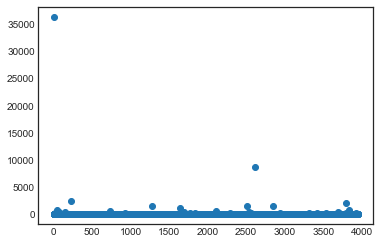

In [55]:
plt.scatter(customer_bulk_df.index.values, customer_bulk_df.Bulk);

One outlier in bulk ranking

Let's delete it

In [57]:
# From main df :
customers_to_drop = customer_bulk_df[customer_bulk_df.Bulk > 30000].index.values
data_stock_codes = data_stock_codes[~data_stock_codes.CustomerID_enc.isin(customers_to_drop)]
# From bulk df :
customer_bulk_df = customer_bulk_df[customer_bulk_df.Bulk < 30000]

Checking

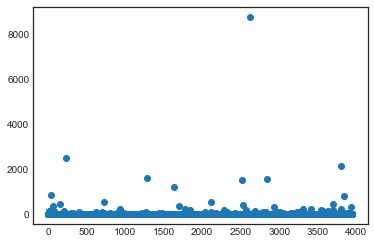

In [58]:
plt.scatter(customer_bulk_df.index.values, customer_bulk_df.Bulk);

What about amount ranking ?

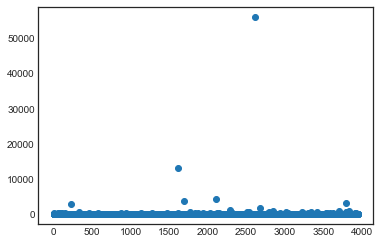

In [59]:
plt.scatter(customer_bulk_df.index.values, customer_bulk_df.Amount);

Two outliers in Amount ranking

Let's delete those

In [60]:
# From main df :
customers_to_drop = customer_bulk_df[customer_bulk_df.Amount > 10000].index.values
data_stock_codes = data_stock_codes[~data_stock_codes.CustomerID_enc.isin(customers_to_drop)]
# From bulk df :
customer_bulk_df = customer_bulk_df[customer_bulk_df.Amount < 10000]

Checking

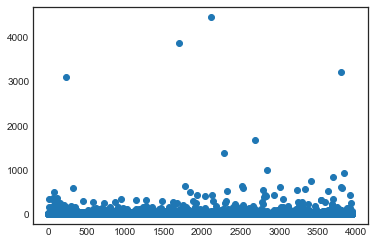

In [61]:
plt.scatter(customer_bulk_df.index.values, customer_bulk_df.Amount);

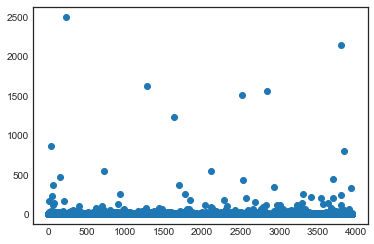

In [62]:
plt.scatter(customer_bulk_df.index.values, customer_bulk_df.Bulk);

Save dataframe for clustering

In [63]:
customer_bulk_df.to_csv("data/customer_bulk.csv", index=True)

Saving the clean dataframe for classification algorithms

In [64]:
data_stock_codes.to_csv("data/online_retail_clean.csv", index=False)